In [1]:
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

## Recall:
Yesterday, we developed a simple differentiable forward model and demonstrated a simple fitting of this forward model: namely, using 100 timesteps along a given trajectory, we can use our physics model and gradient descent to fit the initial position, velocity, and acceleration.

As a reminder: our forward model is one function

In [2]:
def position(t, a, x0, v0):
    return x0 + v0*t + 0.5*a*t**2

which takes in parameters and (measurement) time steps

In [3]:
#Acceleration due to gravity (-9.8 m/s^2 in negative y direction)
a_target = torch.tensor([0, -9.8])[None, :]

#Initial velocity for fun (m / s)
v0_target = torch.tensor([5, 10])[None, :]

#Start at (0,10) [m]
x0_target = torch.tensor([0,10])[None, :]

#Data taken at 100 known timesteps from 0 to 5 s
time_steps = torch.linspace(0, 5, 100)[:, None]

In [4]:
trajectory_target = position(time_steps, a_target, x0_target, v0_target)

## Today: Who needs differentiable simulators, anyway?

Rather than doing a parameter fitting with a differentiable forward model, we can also frame this fitting as a data-driven regression problem: namely given known trajectories $X$, corresponding parameters $\theta$, learn a model $f$ such that:

\begin{equation}
f(X) = \theta
\end{equation}

This is a fairly straightforward supervised learning problem -- let's try this out with a simple multi-layer perceptron (MLP). With PyTorch, we can make this as follows:

In [5]:
from torch import nn

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Define layers -- we include 1 hidden layer for fun
        self.layers = nn.Sequential(
                          nn.Flatten(),
                          nn.Linear(200, 50),
                          nn.ReLU(),
                          nn.Linear(50, 6)
                        )


    def forward(self, x):
        out = self.layers(x)
        out = out.reshape((-1, 3, 2))
        return out

We can then set up inputs and targets with appropriate dimensions. Let's do a single point to show that it works, but we'll add a new array dimension to allow for multiple trajectories (the "batch dimension").

In [6]:
inputs = trajectory_target[None, :, :]
targets = torch.stack([a_target, x0_target, v0_target]).squeeze()[None, ...]

The training loop should look pretty familiar from yesterday:

In [7]:
# Initialize the MLP
mlp = MLP()

# Define the loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-4)

# Run the training loop
for epoch in tqdm(range(1000)): 

    # Zero the gradients
    optimizer.zero_grad()

    # Perform forward pass
    outputs = mlp(inputs)

    # Compute loss
    loss = loss_fn(outputs, targets)

    # Perform backward pass
    loss.backward()

    # Perform optimization
    optimizer.step()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1870.87it/s]


and it converges, as we expect

In [8]:
outputs, targets

(tensor([[[ 9.5367e-07, -9.8000e+00],
          [ 1.1176e-06,  1.0000e+01],
          [ 5.0000e+00,  1.0000e+01]]], grad_fn=<ReshapeAliasBackward0>),
 tensor([[[ 0.0000, -9.8000],
          [ 0.0000, 10.0000],
          [ 5.0000, 10.0000]]]))

We can try a not as silly example with some set of trajectories to learn some meaningful parameter estimation -- let's just do a range of different accelerations for simplicity, and include a validation set just to check

v0 and x0 is the same for everything, we use torch.tile to repeat it a relevant number of times

In [9]:
train_size = 50
valid_size = 50

#Initial velocity for fun (m / s)
v0s = torch.tile(torch.tensor([5., 10.])[None, :], (train_size+valid_size, 1, 1))

#Start at (0,10) [m]
x0s = torch.tile(torch.tensor([0.,10.])[None, :], (train_size+valid_size, 1, 1))

#Data taken at 100 known timesteps from 0 to 5 s
time_steps = torch.linspace(0, 5, 100)[None, :, None]

Take some range of y-accelerations

In [10]:
acc_range = torch.linspace(-12, 12, train_size+valid_size)

and then construct training and validation sets (seeding for reproducibility)

In [11]:
torch.manual_seed(0)
rand_idxs = torch.randperm(train_size+valid_size)
train_idxs = rand_idxs[:train_size]
valid_idxs = rand_idxs[valid_size:]

In [12]:
accs_train = torch.zeros(size=(train_size, 1, 2))
accs_train[:, :, 1] = acc_range[train_idxs][:, None]

v0s_train =  v0s[train_idxs]
x0s_train = x0s[train_idxs]

trajectories_target_train = position(time_steps, accs_train, x0s_train, v0s_train)

In [13]:
accs_valid = torch.zeros(size=(valid_size, 1, 2))
accs_valid[:, :, 1] = acc_range[valid_idxs][:, None]

v0s_valid =  v0s[valid_idxs]
x0s_valid = x0s[valid_idxs]

trajectories_target_valid = position(time_steps, accs_valid, x0s_valid, v0s_valid)

Package into appropriate shape

In [14]:
inputs = trajectories_target_train
targets = torch.cat((accs_train, x0s_train, v0s_train), dim=1)

inputs_val = trajectories_target_valid
targets_val = torch.cat((accs_valid, x0s_valid, v0s_valid), dim=1)

And then train real quick

In [15]:
# Initialize the MLP
mlp = MLP()

# Define the loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-5)

losses = []
losses_val = []
# Run the training loop
for epoch in tqdm(range(20000)): 

    # Zero the gradients
    optimizer.zero_grad()

    # Perform forward pass
    outputs = mlp(inputs)

    # Compute loss
    loss = loss_fn(outputs, targets)
    
    with torch.no_grad():
        out_valid = mlp(inputs_val)
        loss_valid = loss_fn(out_valid, targets_val)
        losses_val.append(loss_valid)

    # Perform backward pass
    loss.backward()

    # Perform optimization
    optimizer.step()
    
    losses.append(loss.item())

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [00:12<00:00, 1575.41it/s]


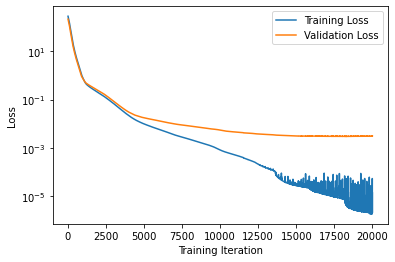

In [16]:
plt.plot(losses, label='Training Loss')
plt.plot(losses_val, label='Validation Loss')
plt.yscale('log')
plt.legend()
plt.xlabel('Training Iteration')
plt.ylabel('Loss')
plt.show()

Let's test the MLP prediction by a) sampling more finely and b) expanding the range of acceleration values considered

In [17]:
n_test = 300
#Acceleration due to gravity (-9.8 m/s^2 in negative y direction)
accs_test = torch.zeros(size=(n_test, 1, 2))
accs_test[:, :, 1] = torch.linspace(-13, 13, n_test)[:, None]

#Initial velocity for fun (m / s)
v0s = torch.tile(torch.tensor([5, 10])[None, :], (n_test, 1, 1))

#Start at (0,10) [m]
x0s = torch.tile(torch.tensor([0,10])[None, :], (n_test, 1, 1))

#Data taken at n_test known timesteps from 0 to 5 s
time_steps = torch.linspace(0, 5, 100)[None, :, None]

trajectories_test = position(time_steps, accs_test, x0s, v0s)

In [18]:
pred = mlp(trajectories_test).detach()
ax_test = pred[:, 0, 0]
ay_test = pred[:, 0, 1]

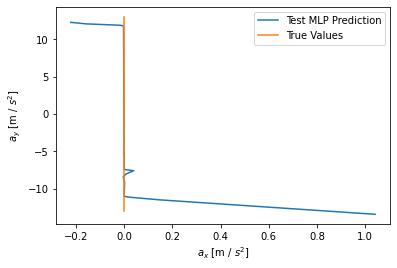

In [19]:
plt.plot(ax_test, ay_test, label='Test MLP Prediction')
plt.plot(accs_test[:, 0, 0], accs_test[:, 0, 1], label='True Values')
plt.xlabel('$a_{x}$ [m / $s^2$]')
plt.ylabel('$a_{y}$ [m / $s^2$]')
plt.legend()
#plt.xlim(-0.1, 0.1)
plt.show()

Plotting the training points can be revealing:

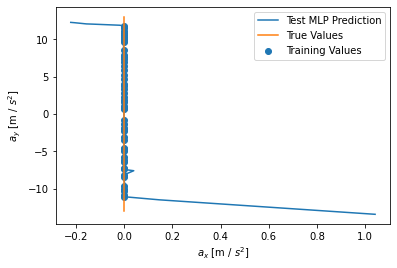

In [20]:
plt.plot(ax_test, ay_test, label='Test MLP Prediction')
plt.plot(accs_test[:, 0, 0], accs_test[:, 0, 1], label='True Values')
plt.scatter(accs_train[:, 0, 0], accs_train[:, 0, 1], label='Training Values')
plt.xlabel('$a_{x}$ [m / $s^2$]')
plt.ylabel('$a_{y}$ [m / $s^2$]')
plt.legend()
#plt.xlim(-0.1, 0.1)
plt.show()

The MLP predictions for acceleration are very close to true values within the training range, but diverge as we go away from the training points -- we can, of course, make better models, but this emphasizes a point -- the MLP is fitting to training data, but has no explicit knowledge of the physics. 

But -- we've learned a (very simple) data-driven model for parameter estimation

## Why is this useful? 

Yesterday, we showed that given (1) a physics model (our differentiable forward model) and (2) a target trajectory, we could use gradient descent to learn the parameters of the target. 

In symbols, we have a simulator $\Phi$ that maps from parameters $\theta$ to trajectories $X$, or:

\begin{equation}
\Phi(\theta) = X.
\end{equation}

We can solve for the parameters of an arbitrary trajectory by _explicitly_ iterating on input parameters: namely comparing the output trajectory from some initial parameter guess and using backpropagation/gradient descent to update this parameter guess.


Today, we have demonstrated that with no physics model, but with a set of trajectories and parameters, we can do a supervised training of a neural network to create a map from trajectories to parameters, namely, calling this map $f$, we learn

\begin{equation}
f(X) = \theta.
\end{equation}




This supervised training is nice, and it works, but what if we only have the simulator and some data? Can we still learn f? It turns out, yes! We can do so with what we'll call a cycle-consistent loss, namely, if we chain together f and $\Phi$, we get a mapping:

\begin{equation}
\Phi\circ f: X \rightarrow \theta \rightarrow X'.
\end{equation}

In words, if we pass a set of trajectories through both $f$ and $\Phi$, we get a new set of trajectories. Since $\Phi$ is differentiable, we can backpropagate to update the parameters of $f$. In particular, if we define the loss such that $\Phi\circ f$ tries to reconstruct the input trajectories ($\Phi\circ f(X) = X$), we should _implicitly_ learn a mapping from $X$ to $\theta$. That was a lot of words, so let's try it!

### Exercise:

Using the existing `MLP` class from above and our differentiable simulator (the `position` function), write a chunk of code that goes from trajectories to parameters and back to trajectories. Don't worry about training just yet! Skeleton to help:

In [21]:
# Keep time steps fixed
timesteps = torch.linspace(0, 5, 100)[:, None]

# Initialize MLP (we'll train it later)
mlp = MLP()

# Go from inputs to parameters (output tensor shape n_batch x n_params x 2 spatial dims)


# Reshape to extract individual params. Big hint:

# Adds extra dim at position 1 (shape n_batch x filler timestep dim x n_params x 2 spatial dims)
# parameters = torch.unsqueeze(parameters, 1)

# Unpack to individual params (a is shape n_batch x 1 x 2, e.g.)
#a = parameters[:, :, 0]
#v0 = parameters[:, :, 1]
#x0 = parameters[:, :, 2]

# Go from parameters to trajectories 



### Answer:

In [22]:
# Keep time steps fixed
timesteps = torch.linspace(0, 5, 100)[:, None]

# Initialize MLP (we'll train it later)
mlp = MLP()

# Use MLP to map from inputs to parameters
parameters = mlp(inputs)

# We need to match up shapes:

# Adds extra dim at position 1 ("timestep" dimension)
parameters = torch.unsqueeze(parameters, 1)

# Unpack to individual params
a = parameters[:, :, 0]
v0 = parameters[:, :, 1]
x0 = parameters[:, :, 2]

# Pass through forward model
trajectories = position(timesteps, a, v0, x0)

We can think of _encoding_ trajectories into a parameter space using the MLP, and then _decoding_ the parameters to trajectories with our forward model. This type of structure is known as an _autoencoder_. Let's make this explicit by repackaging the example within the MLP class: 

In [23]:
class MLP_autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Same MLP from above
        self.layers = nn.Sequential(
                          nn.Flatten(),
                          nn.Linear(200, 50),
                          nn.ReLU(),
                          nn.Linear(50, 6)
                        )
        
        # We're keeping time steps fixed for this tutorial
        self.timesteps = torch.linspace(0, 5, 100)[:, None]

    # Map from trajectories to parameters by applying the MLP
    def encode(self, x):
        out = self.layers(x)
        out = out.reshape((-1, 3, 2))
        return out
    
    # Reshape and map from parameters to trajectories
    def decode(self, params):
        params = torch.unsqueeze(params, 1)
        a = params[:, :, 0]
        v0 = params[:, :, 1]
        x0 = params[:, :, 2]
        return position(self.timesteps, a, v0, x0)
    
    # Forward run is decode(encode(x))
    def forward(self, x):
        enc = self.encode(x)
        dec = self.decode(enc)
        return dec

The fun thing with this tutorial is that **only the encoder is learnable** -- the decoder is fixed, and given by the forward model. 

Crucially, however, our decoder is differentiable, otherwise we wouldn't be able to train this autoencoder via backpropagation!

Speaking of training, let's look at the same training set as before:

In [24]:
train_size = 50
valid_size = 50

#Initial velocity for fun (m / s)
v0s = torch.tile(torch.tensor([5., 10.])[None, :], (train_size+valid_size, 1, 1))

#Start at (0,10) [m]
x0s = torch.tile(torch.tensor([0.,10.])[None, :], (train_size+valid_size, 1, 1))

#Data taken at 100 known timesteps from 0 to 5 s
time_steps = torch.linspace(0, 5, 100)[None, :, None]

Take some range of y-accelerations

In [25]:
acc_range = torch.linspace(-12, 12, train_size+valid_size)

and then construct training and validation sets (seeding for reproducibility)

In [26]:
torch.manual_seed(0)
rand_idxs = torch.randperm(train_size+valid_size)
train_idxs = rand_idxs[:train_size]
valid_idxs = rand_idxs[valid_size:]

In [27]:
accs_train = torch.zeros(size=(train_size, 1, 2))
accs_train[:, :, 1] = acc_range[train_idxs][:, None]

v0s_train =  v0s[train_idxs]
x0s_train = x0s[train_idxs]

trajectories_target_train = position(time_steps, accs_train, x0s_train, v0s_train)

In [28]:
accs_valid = torch.zeros(size=(valid_size, 1, 2))
accs_valid[:, :, 1] = acc_range[valid_idxs][:, None]

v0s_valid =  v0s[valid_idxs]
x0s_valid = x0s[valid_idxs]

trajectories_target_valid = position(time_steps, accs_valid, x0s_valid, v0s_valid)

Package into appropriate shape

In [29]:
inputs = trajectories_target_train
targets = torch.cat((accs_train, x0s_train, v0s_train), dim=1)

inputs_val = trajectories_target_valid
targets_val = torch.cat((accs_valid, x0s_valid, v0s_valid), dim=1)

Now we have something very interesting! We can learn the encoder in a supervised way (as we did above), but, we also no longer need explict labels! Namely, since the autoencoder maps from trajectories to trajectories, we only ever need to compare trajectories!


A particularly useful case is when we set our targets to learn:

\begin{equation}
\Phi \circ f(X) = X
\end{equation}

namely, we try to reconstruct the inputs. We can then _implicitly_ learn trajectory parameters. The training loop looks like:

In [30]:
# Initialize the MLP
mlp_auto = MLP_autoencoder()

# Define the loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(mlp_auto.parameters(), lr=1e-5)

losses = []
losses = []
losses_val = []
# Run the training loop
for epoch in tqdm(range(20000)): 

    # Zero the gradients
    optimizer.zero_grad()
    
    outputs = mlp_auto(inputs)
    
    # Compute loss
    loss = loss_fn(outputs, inputs)
    
    with torch.no_grad():
        out_valid = mlp_auto(inputs_val)
        loss_valid = loss_fn(out_valid, inputs_val)
        losses_val.append(loss_valid)

    # Perform backward pass
    loss.backward()

    # Perform optimization
    optimizer.step()
    
    losses.append(loss.item())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [00:25<00:00, 779.93it/s]


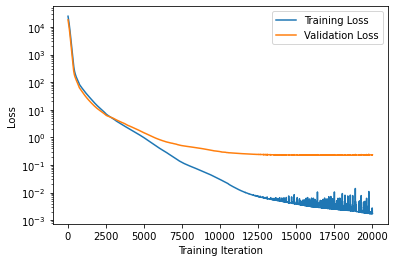

In [31]:
plt.plot(losses, label='Training Loss')
plt.plot(losses_val, label='Validation Loss')
plt.yscale('log')
plt.legend()
plt.xlabel('Training Iteration')
plt.ylabel('Loss')
plt.show()

Let's test the MLP prediction by a) sampling more finely and b) expanding the range of acceleration values considered

In [32]:
#Acceleration due to gravity (-9.8 m/s^2 in negative y direction)
accs_test = torch.zeros(size=(100, 1, 2))
accs_test[:, :, 1] = torch.linspace(-14, 14, 100)[:, None]

#Initial velocity for fun (m / s)
v0s = torch.tile(torch.tensor([5, 10])[None, :], (100, 1, 1))

#Start at (0,10) [m]
x0s = torch.tile(torch.tensor([0,10])[None, :], (100, 1, 1))

#Data taken at 100 known timesteps from 0 to 5 s
time_steps = torch.linspace(0, 5, 100)[None, :, None]

trajectories_test = position(time_steps, accs_test, x0s, v0s)

In [33]:
pred = mlp_auto.encode(trajectories_test).detach()
ax_test = pred[:, 0, 0]
ay_test = pred[:, 0, 1]

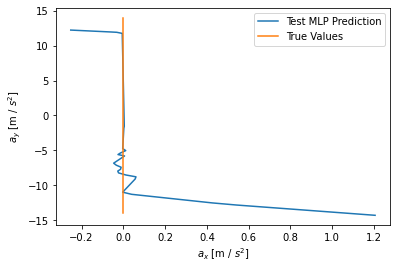

In [34]:
plt.plot(ax_test, ay_test, label='Test MLP Prediction')
plt.plot(accs_test[:, 0, 0], accs_test[:, 0, 1], label='True Values')
plt.xlabel('$a_{x}$ [m / $s^2$]')
plt.ylabel('$a_{y}$ [m / $s^2$]')
plt.legend()
#plt.xlim(-0.1, 0.1)
plt.show()

It works! And with the training points:

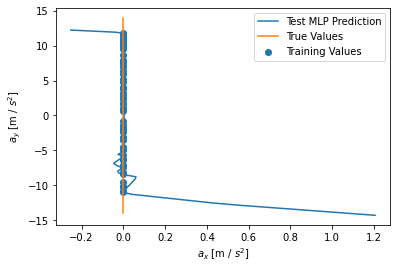

In [35]:
plt.plot(ax_test, ay_test, label='Test MLP Prediction')
plt.plot(accs_test[:, 0, 0], accs_test[:, 0, 1], label='True Values')
plt.scatter(accs_train[:, 0, 0], accs_train[:, 0, 1], label='Training Values')
plt.xlabel('$a_{x}$ [m / $s^2$]')
plt.ylabel('$a_{y}$ [m / $s^2$]')
plt.legend()
#plt.xlim(-0.1, 0.1)
plt.show()

The fully supervised setting and this unsupervised parameter learning do not have to be distinct! We can use this physics model decoding as a _regularizer_ in a fully supervised setting.

### Exercise: 
Using the MLP autoencoder class, write down a loss that is the sum of the fully supervised loss and the unsupervised autoencoder loss. Use `inputs` as the input trajectories, `targets` as the parameter targets. Skeleton:

In [36]:
# Initialize
mlp_auto = MLP_autoencoder()

# Use MSE loss for both
loss_fn = nn.MSELoss()

# Calculate predicted parameters given input trajectories (encode)

# Calculate predicted trajectories given input trajectories

# Calculate loss between predicted parameters and target

# Calculate loss between predicted trajectories and inputs

# Sum them up for total loss -- introduce a regularization strength on the autoencoder loss



### Answer (in a training loop)

In [38]:
# Initialize the MLP
mlp_auto = MLP_autoencoder()

# Define the loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(mlp_auto.parameters(), lr=1e-5)
reg = 0.8

losses = []
losses_val = []
# Run the training loop
for epoch in tqdm(range(20000)): 

    # Zero the gradients
    optimizer.zero_grad()
    
    output_params = mlp_auto.encode(inputs)
    output_traj = mlp_auto(inputs)
    
    # Compute loss
    loss = loss_fn(output_params, targets) + reg*loss_fn(output_traj, inputs)
    
    with torch.no_grad():
        output_params_val = mlp_auto.encode(inputs_val)
        output_traj_val = mlp_auto(inputs_val)
        loss_valid = loss_fn(output_params_val, targets_val)+ reg*loss_fn(output_traj_val, inputs_val)
        losses_val.append(loss_valid)

    # Perform backward pass
    loss.backward()

    # Perform optimization
    optimizer.step()
    
    losses.append(loss.item())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [00:29<00:00, 667.44it/s]


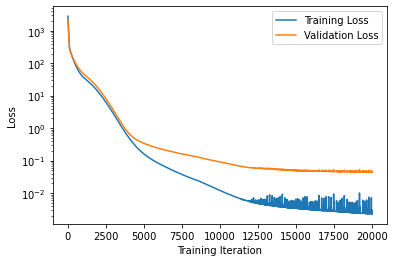

In [39]:
plt.plot(losses, label='Training Loss')
plt.plot(losses_val, label='Validation Loss')
plt.yscale('log')
plt.legend()
plt.xlabel('Training Iteration')
plt.ylabel('Loss')
plt.show()

In [40]:
pred = mlp_auto.encode(trajectories_test).detach()
ax_test = pred[:, 0, 0]
ay_test = pred[:, 0, 1]

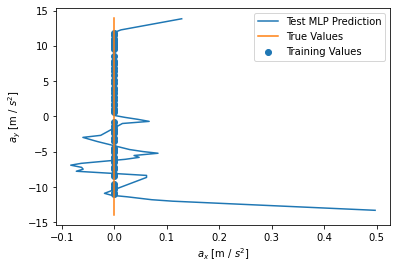

In [41]:
plt.plot(ax_test, ay_test, label='Test MLP Prediction')
plt.plot(accs_test[:, 0, 0], accs_test[:, 0, 1], label='True Values')
plt.scatter(accs_train[:, 0, 0], accs_train[:, 0, 1], label='Training Values')
plt.xlabel('$a_{x}$ [m / $s^2$]')
plt.ylabel('$a_{y}$ [m / $s^2$]')
plt.legend()
#plt.xlim(-0.1, 0.1)
plt.show()

In this simple case, we don't necessariy expect a big impact -- but it's a useful strategy to keep in mind!

## Advantages of autoencoder setup vs standard MLP

In the above autoencoder setup, we saw that we could achieve similar results as the fully supervised training. But our only input was trajectories! In that sense, our test set isn't super meaningful -- we have a setup that will fit to our data in much the same way as our autodiff solution from yesterday. If the reconstruction is good, we can be confident in our parameter values.

Let's demonstrate this for a single trajectory. Training is much the same as usual:

In [42]:
inputs = trajectory_target[None, :, :]
targets = torch.stack([a_target, x0_target, v0_target]).squeeze()[None, ...]

In [43]:
# Initialize the MLP
mlp_auto = MLP_autoencoder()

# Define the loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(mlp_auto.parameters(), lr=1e-4)

# Run the training loop
for epoch in tqdm(range(5000)): 

    # Zero the gradients
    optimizer.zero_grad()

    # Perform forward pass
    outputs = mlp_auto(inputs)

    # Compute loss
    loss = loss_fn(outputs, inputs)

    # Perform backward pass
    loss.backward()

    # Perform optimization
    optimizer.step()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:03<00:00, 1525.35it/s]


And converges well -- input and output trajectories match:

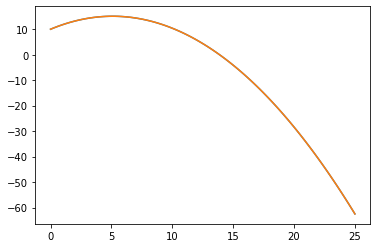

In [44]:
plt.plot(outputs.detach().numpy()[0, :, 0], outputs.detach().numpy()[0, :, 1])
plt.plot(inputs.numpy()[0, :, 0], inputs.numpy()[0, :, 1])
plt.show()

And the outputs of the encoder match the "true" parameters:

In [45]:
mlp_auto.encode(inputs).detach(), targets

(tensor([[[ 9.2387e-07, -9.8000e+00],
          [ 3.2783e-07,  1.0000e+01],
          [ 5.0000e+00,  1.0000e+01]]]),
 tensor([[[ 0.0000, -9.8000],
          [ 0.0000, 10.0000],
          [ 5.0000, 10.0000]]]))

This particular network doesn't generalize well:

In [46]:
pred = mlp_auto.encode(trajectories_test).detach()
ax_test = pred[:, 0, 0]
ay_test = pred[:, 0, 1]

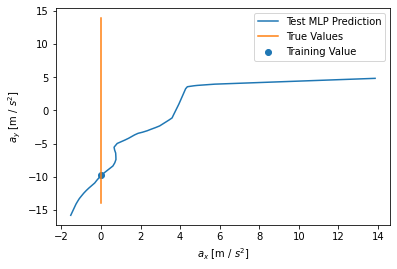

In [47]:
plt.plot(ax_test, ay_test, label='Test MLP Prediction')
plt.plot(accs_test[:, 0, 0], accs_test[:, 0, 1], label='True Values')
plt.scatter(a_target[:, 0], a_target[:, 1], label='Training Value')
plt.xlabel('$a_{x}$ [m / $s^2$]')
plt.ylabel('$a_{y}$ [m / $s^2$]')
plt.legend()
#plt.xlim(-0.1, 0.1)
plt.show()

In [48]:
trajectories_test.shape, inputs.shape

(torch.Size([100, 100, 2]), torch.Size([1, 100, 2]))

But we don't expect it to! We have no dependence on the true labels, so there's no problem with running a fit for any arbitrary trajectory: 

In [49]:
pred_a = []
check_idxs = [0, 10, 50, 99]
for traj in tqdm(trajectories_test[check_idxs]):
    traj = torch.unsqueeze(traj, 0)
    
    # Initialize the MLP
    mlp_auto = MLP_autoencoder()

    # Define the loss function and optimizer
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(mlp_auto.parameters(), lr=1e-4)

    # Run the training loop
    for epoch in range(5000): 

        # Zero the gradients
        optimizer.zero_grad()

        # Perform forward pass
        outputs = mlp_auto(traj)

        # Compute loss
        loss = loss_fn(outputs, traj)

        # Perform backward pass
        loss.backward()

        # Perform optimization
        optimizer.step()
    
    pred_a.append(mlp_auto.encode(traj)[:, 0, :].detach())
    
pred_a = torch.stack(pred_a)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:12<00:00,  3.17s/it]


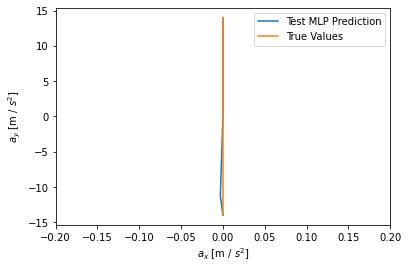

In [50]:
plt.plot(pred_a[:, 0, 0], pred_a[:, 0, 1], label='Test MLP Prediction')
plt.plot(accs_test[:, 0, 0], accs_test[:, 0, 1], label='True Values')
plt.xlabel('$a_{x}$ [m / $s^2$]')
plt.ylabel('$a_{y}$ [m / $s^2$]')
plt.legend()
plt.xlim(-0.2, 0.2)
plt.show()

## Why don't we just autodiff? Noisy inputs and encoding
Now suppose we have some measurement noise, which we'll assume to be Gaussian for simplicity. We can make the same measurement multiple times, which gives us a bit more info:

In [51]:
noisy_target = trajectory_target + torch.normal(torch.zeros((500,)+trajectory_target.shape), 
                                                torch.ones((500,)+trajectory_target.shape)*0.2)

In [52]:
noisy_target.shape

torch.Size([500, 100, 2])

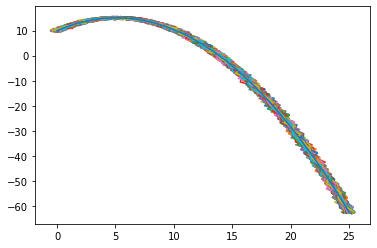

In [53]:
for i in range(len(noisy_target)):
    plt.plot(noisy_target[i, :, 0], noisy_target[i, :, 1])
plt.plot(trajectory_target[:, 0], trajectory_target[:, 1])
plt.show()

We might expect noise on the input to translate into some uncertainty on the fitted trajectory parameters. How do we estimate this? A first naive thing to do is try to learn parameters for each measurement -- we'll do so with our autoencoder setup for now:

In [54]:
inputs = noisy_target.clone()

In [55]:
# Initialize the MLP
mlp_auto = MLP_autoencoder()

# Define the loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(mlp_auto.parameters(), lr=1e-4)

losses = []
# Run the training loop
for epoch in tqdm(range(3000)): 

    # Zero the gradients
    optimizer.zero_grad()

    # Perform forward pass
    outputs = mlp_auto(inputs)

    # Compute loss
    loss = loss_fn(outputs, inputs)

    # Perform backward pass
    loss.backward()

    # Perform optimization
    optimizer.step()
    
    losses.append(loss.item())

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:07<00:00, 393.17it/s]


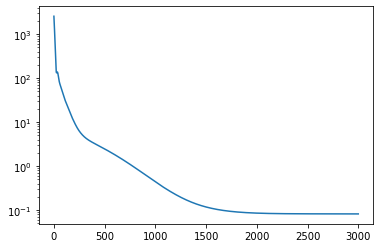

In [56]:
plt.plot(losses)
plt.yscale('log')

Then, let's take a look at our learned parameter values:

In [57]:
params = mlp_auto.encode(inputs).detach()

In [58]:
a_vals = params[:, 0, :]
x0_vals = params[:, 1, :]
v0_vals = params[:, 2, :]

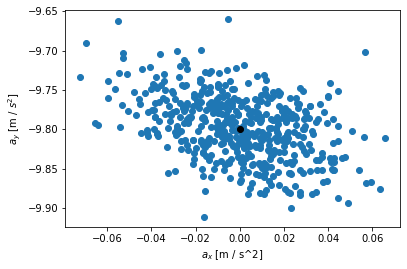

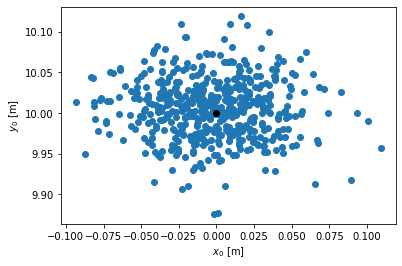

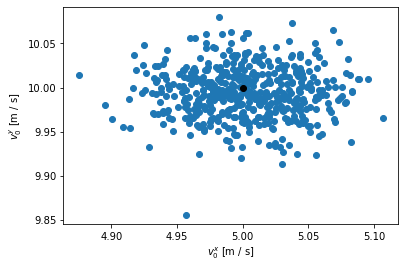

In [59]:
plt.scatter(a_vals[:, 0], a_vals[:, 1])
plt.scatter(a_target[:, 0], a_target[:, 1], c='k')
plt.xlabel('$a_x$ [m / s^2]') 
plt.ylabel('$a_y$ [m / $s^2$]')
plt.show()


plt.scatter(x0_vals[:, 0], x0_vals[:, 1])
plt.scatter(x0_target[:, 0], x0_target[:, 1], c='k')
plt.xlabel('$x_{0}$ [m]') 
plt.ylabel('$y_{0}$ [m]')
plt.show()

plt.scatter(v0_vals[:, 0], v0_vals[:, 1])
plt.scatter(v0_target[:, 0], v0_target[:, 1], c='k')
plt.xlabel('$v_{0}^{x}$ [m / s]') 
plt.ylabel('$v_{0}^{y}$ [m / s]')
plt.show()

The noise on the input results in some _distribution_ of fitted parameter values -- we now have a pipeline to automatically translate a distribution over trajectories into a distribution over parameters! Using this to naively get parameter values + an uncertainty (assuming diagonal Gaussian):

In [60]:
from math import sqrt
mean_acc = torch.mean(a_vals, axis=0)

#Std error has factor of 1/sqrt(N)
N = len(a_vals)
std_acc = torch.std(a_vals, axis=0)

print(f'x acceleration: {mean_acc[0]:.2f} +/- {std_acc[0]/sqrt(N):.3f} m / s^2')
print(f'y acceleration: {mean_acc[1]:.2f} +/- {std_acc[1]/sqrt(N):.3f} m / s^2')

x acceleration: -0.00 +/- 0.001 m / s^2
y acceleration: -9.80 +/- 0.002 m / s^2


Having a latent space distribution available opens up a variety of possibilities. One might consider, e.g., Variational Autoencoders, which impose some prior on the learned latent space via an additional KL divergence term in the loss. With a physically meaningful latent space, this can get a bit involved, so we leave this for future work. But, the structure is a fairly simple (few line) extension of the autoencoder we've developed above!

## Conclusions:
 
Differentiable physics simulators allow us to leverage the power of automatic differentiation within a physics motivated context. 

In day 1, we demonstrated that such simulators can be used for parameter fitting (e.g. calibration) and inverse problem solving via gradient descent.

Today, we showed that this differentiability allows us to use physics models in conjunction with tools such as neural networks. This allows for physics based regularization of such networks, unsupervised learning of physical parameters, and access to corresponding physically meaningful latent spaces. 

The examples that we showed are simple, but hopefully will give a starting place for future work! Please feel free to reach out with any questions!